In [ ]:
"""
seleccion:
    'elitist'
    'roulette_wheel'
    'boltzmann'  usa pseudo-performance roulette_wheel
    'universal_selection'   
    'deterministic_tournament'
    'stochastic_tournament'
    'rank_based'    usa pseudo-performance roulette_wheel

crossover:
    'one_point'
    'two_point'
    'uniform'
    'annular'

mutation:
    'one_gene'
    'multi_gene'
    'multi_gene_mutation_uniform'
"""

#### Setup

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.8e}'.format

import configparser
from collections import defaultdict
from src.character import Character, CharacterType 
from src.stats import random_stats
from src.genes import  encode_genes, decode_genes
from src.mutation import one_gene_mutation, multi_gene_mutation, multi_gene_mutation_uniform

import sys
sys.path.append("src")

from src.population import generate_init_population, eval_performace
from src.selection import stochastic_tournament_selection, deterministic_tournament_selection, add_relative_accumulate, elitist_selection, roulette_wheel_selection, universal_selection, boltzmann_selection, rank_based_selection
from src.crossover import single_point_crossover, two_point_crossover, uniform_crossover, annular_crossover, normalize_chromosome


In [2]:
from collections import namedtuple

def read_config(filename):
    config = configparser.ConfigParser()
    config.read(filename)
    params = defaultdict(dict)
    for section in config.sections():
        for key, value in config.items(section):
            params[section][key] = value
    return params

#params = read_config('config_file.config')

def parameters():
    
    config_params = read_config('config_file.config')

    # Personaje 
    type = eval(config_params['CHARACTER']['type'])
    
    # sum( stats ) = 150
    maxStatsValue = eval(config_params['M']['m'])
    
    # N
    populationNumber = eval(config_params['N']['n'])
    # K
    k = eval(config_params['K']['k'])

    # Numero máximo de generaciones - criterio de corte
    numberOfGenerations = eval(config_params['GENERATIONS']['number'])
    
    # A%
    method1Percentage = eval(config_params['METHOD1PERCENTAGE']['percentage'])
    selectionMethod1 = eval(config_params['SELECTION_METHOD']['method1'])
    selectionMethod2 = eval(config_params['SELECTION_METHOD']['method2'])
   
    # CrossOver
    metodo_cruza = eval(config_params['metodo_cruza']['crossover'])
 
    # Mutation
    mutation_type = eval(config_params['MUTATION']['mutation_type'])
    mutation_rate = eval(config_params['MUTATION']['mutation_rate'])

    # B%
    methodReplacePercentage = eval(config_params['METHODRePERCENTAGE']['percentage'])
    metodo_reemplazo3 = eval(config_params['metodo_reemplazo']['metodo1'])
    metodo_reemplazo4 = eval(config_params['metodo_reemplazo']['metodo2'])

    cutCriteria = eval(config_params['CUT_CRITERIA']['criteria_type'])
    
    # Selector parameters
    # M
    tournament_size = eval(config_params['deterministic_tournament_selection']['tournament_size'])
    # stochastic_tournament_selection
    threhold = eval(config_params['stochastic_tournament_selection']['threshold'])
    # Boltzmann parameters
    boltzmannT_0 = eval(config_params['BOLTZMANN']['t_0'])
    boltzmannT_c = eval(config_params['BOLTZMANN']['t_c'])
    boltzmannM = eval(config_params['BOLTZMANN']['m'])

    Param = namedtuple('Param',[
        'character',
        'maxStatsValue',
        'populationNumber',
        'k',
        'numberOfGenerations',
        'method1Percentage',
        'selectionMethod1',
        'selectionMethod2',
        'metodo_cruza',
        'mutation_type',
        'mutation_rate',
        'methodReplacePercentage',
        'metodo_reemplazo3',
        'metodo_reemplazo4',
        'cutCriteria',
        'tournament_size',
        'threhold',
        'boltzmannT_0',
        'boltzmannT_c',
        'boltzmannM'
    ])    

    parametros = Param(
                character=type,
                maxStatsValue=maxStatsValue,
                populationNumber=populationNumber,
                k=k,
                numberOfGenerations=numberOfGenerations,
                method1Percentage=method1Percentage,
                selectionMethod1=selectionMethod1,
                selectionMethod2=selectionMethod2,
                metodo_cruza=metodo_cruza,
                mutation_type=mutation_type,
                mutation_rate=mutation_rate,
                methodReplacePercentage=methodReplacePercentage,
                metodo_reemplazo3=metodo_reemplazo3,
                metodo_reemplazo4=metodo_reemplazo4,
                cutCriteria=cutCriteria,
                tournament_size=tournament_size,
                threhold=threhold,
                boltzmannT_0=boltzmannT_0,
                boltzmannT_c=boltzmannT_c,
                boltzmannM=boltzmannM
    )

    return parametros

#p = parameters()


In [ ]:
"""
from src.character import Character, CharacterType 
import sys
sys.path.append("src")

from src.population import generate_init_population

#GENERACION 0

generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)
generacion = 0
"""


In [ ]:
"""
# GUARDO EL MAS APTO DE LA GENERACION 0
# Escribe la poblacion inicial.
#generation_0.insert(0, 'generation', int(generacion))
generation_0['generation'] = generacion
mas_apto_G0 = generation_0.head(1)
mas_apto_G0.to_csv(f'datos-Prueba1.csv', mode='w', index=False)
"""


#### Functions

In [3]:

def method_selector(Kt, method1Percentage): 
    # Selecciono K individuos
    # Utilizo el porcentaje para cada método
    K1 = int(np.round(Kt * method1Percentage))
    K2 = Kt - K1
    return K1, K2

#k1, k2 = method_selector(p.k, p.method1Percentage)

In [12]:
#current_generation = generation_0
#generacion = 0

In [13]:
def selection_method(poblacion, ki, params, method, generation):

    if(method == 'elitist'):
        selected = elitist_selection(poblacion, ki)
    elif(method == 'roulette_wheel'):
        selected = roulette_wheel_selection(poblacion, ki)
    elif(method == 'boltzmann'):
        selected = boltzmann_selection(poblacion, ki, generation, params.boltzmannT_0,params.boltzmannT_c,params.boltzmannM)
    elif(method == 'universal_selection'):
        selected = universal_selection(poblacion, ki)
    elif(method == 'deterministic_tournament'):
        selected = deterministic_tournament_selection(poblacion, params.tournament_size, ki)
    elif(method == 'stochastic_tournament'):
        selected = stochastic_tournament_selection(poblacion, ki, params.threhold)
    elif(method == 'rank_based'):
        selected = rank_based_selection(poblacion, ki)
    return selected
"""
# SELECCION DE PADRES
generacion_sel1 = selection_method(current_generation, k1, p, p.selectionMethod1, generacion)
generacion_sel2 = selection_method(current_generation, k2, p, p.selectionMethod2, generacion)

# SELECCION TOTAL: K padres
selection_total = pd.concat([generacion_sel1, generacion_sel2])

selection_total.drop(columns=['performance_relative'], inplace=True)
selection_total.drop(columns=['performance_accumulated'], inplace=True)
selection_total = selection_total.sort_values(by='performance', ascending=False)
selection_total.reset_index(drop=True, inplace=True)
"""


"\n# SELECCION DE PADRES\ngeneracion_sel1 = selection_method(current_generation, k1, p, p.selectionMethod1, generacion)\ngeneracion_sel2 = selection_method(current_generation, k2, p, p.selectionMethod2, generacion)\n\n# SELECCION TOTAL: K padres\nselection_total = pd.concat([generacion_sel1, generacion_sel2])\n\nselection_total.drop(columns=['performance_relative'], inplace=True)\nselection_total.drop(columns=['performance_accumulated'], inplace=True)\nselection_total = selection_total.sort_values(by='performance', ascending=False)\nselection_total.reset_index(drop=True, inplace=True)\n"

In [6]:
#cromosomas = encode_genes(selection_total)

#cromosomas

In [14]:
def crossover_method(poblacion, method):
    
    if(method == 'one_point'):
        crossed = single_point_crossover(poblacion)
    elif(method == 'two_point'):
        crossed = two_point_crossover(poblacion)
    elif(method == 'uniform'):
        crossed = uniform_crossover(poblacion)
    elif(method == 'annular'):
        crossed = annular_crossover(poblacion)
    
    return crossed

#crossed_result = crossover_method(cromosomas, p.metodo_cruza)

#crossed_result

In [15]:
def mutation_method(poblacion, rate, method):
    
    if(method == 'one_gene'):
        mutated = one_gene_mutation(poblacion, rate)
    elif(method == 'multi_gene'):
        mutated = multi_gene_mutation(poblacion, rate)
    elif(method == 'multi_gene_mutation_uniform'):
        mutated = multi_gene_mutation_uniform(poblacion, rate)
    
    return mutated

#mutation_result = mutation_method(crossed_result, p.mutation_rate, p.mutation_type)

#mutation_result

In [16]:
#cromosomas_norm = normalize_chromosome(mutation_result)

#cromosomas_norm

In [10]:
"""
cromosomas_norm_decode = decode_genes(cromosomas_norm)
offspring = eval_performace(cromosomas_norm_decode,p.character)

offspring = offspring.sort_values(by='performance', ascending=False)
offspring.reset_index(drop=True, inplace=True)

offspring

"""

"\ncromosomas_norm_decode = decode_genes(cromosomas_norm)\noffspring = eval_performace(cromosomas_norm_decode,p.character)\n\noffspring = offspring.sort_values(by='performance', ascending=False)\noffspring.reset_index(drop=True, inplace=True)\n\noffspring\n\n"

In [11]:
"""
# REEMPLAZO
# padres:  selection_total de tamaño K
# hijos: offspring  de tamaño K
# tomo K de los hijos
k_reemplazo_metodo3 = p.k
# el resto para completar N
k_reemplazo_metodo4 = p.populationNumber - p.k

# SELECCION DE PADRES
generacion_reemp1 = selection_method(offspring, k_reemplazo_metodo3, p, p.metodo_reemplazo3, generacion)
generacion_reemp2 = selection_method(selection_total, k_reemplazo_metodo4, p, p.metodo_reemplazo4, generacion)

# SELECCION TOTAL: K padres
new_generation = pd.concat([generacion_reemp1, generacion_reemp2])

new_generation.drop(columns=['performance_relative'], inplace=True)
new_generation.drop(columns=['performance_accumulated'], inplace=True)
new_generation = new_generation.sort_values(by='performance', ascending=False)
new_generation.reset_index(drop=True, inplace=True)

new_generation
"""

"\n# REEMPLAZO\n# padres:  selection_total de tamaño K\n# hijos: offspring  de tamaño K\n# tomo K de los hijos\nk_reemplazo_metodo3 = p.k\n# el resto para completar N\nk_reemplazo_metodo4 = p.populationNumber - p.k\n\n# SELECCION DE PADRES\ngeneracion_reemp1 = selection_method(offspring, k_reemplazo_metodo3, p, p.metodo_reemplazo3, generacion)\ngeneracion_reemp2 = selection_method(selection_total, k_reemplazo_metodo4, p, p.metodo_reemplazo4, generacion)\n\n# SELECCION TOTAL: K padres\nnew_generation = pd.concat([generacion_reemp1, generacion_reemp2])\n\nnew_generation.drop(columns=['performance_relative'], inplace=True)\nnew_generation.drop(columns=['performance_accumulated'], inplace=True)\nnew_generation = new_generation.sort_values(by='performance', ascending=False)\nnew_generation.reset_index(drop=True, inplace=True)\n\nnew_generation\n"

In [ ]:
"""
generacion += 1
# GUARDO EL MAS APTO DE LA GENERACION NUEVA
# Escribe la poblacion inicial.

#new_generation.insert(0, 'generation', int(generacion))
new_generation['generation'] = generacion
mas_apto_NG = new_generation.head(1)
mas_apto_NG.to_csv(f'datos-Prueba1.csv', mode='a', header=False, index=False)
"""

#### Selections

In [17]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

generation_0.to_csv(f'generation0.csv', mode='w', index=False)
generation_0

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,73,47,13,5,12,2.00000000e+00,CharacterType.ARCHER,4.35350819e+01
1,55,64,1,3,27,1.40000000e+00,CharacterType.ARCHER,3.68873670e+01
2,75,15,38,11,11,1.90000000e+00,CharacterType.ARCHER,3.59012906e+01
3,54,31,37,1,27,1.50000000e+00,CharacterType.ARCHER,3.33315267e+01
4,35,41,42,31,1,1.90000000e+00,CharacterType.ARCHER,3.22910430e+01
...,...,...,...,...,...,...,...,...
75,3,97,15,5,30,2.00000000e+00,CharacterType.ARCHER,3.79879272e+00
76,11,1,23,99,16,1.70000000e+00,CharacterType.ARCHER,3.56774757e+00
77,7,33,12,97,1,1.60000000e+00,CharacterType.ARCHER,3.37986942e+00
78,2,33,65,11,39,1.90000000e+00,CharacterType.ARCHER,3.36854240e+00


In [18]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

elitist_selection = elitist_selection(generation_0,p.k)
elitist_selection.to_csv(f'elitist_selection.csv', mode='w', index=False)

elitist_selection

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,57,54,16,3,20,1.90000000e+00,CharacterType.ARCHER,4.65727003e+01
1,34,32,70,10,4,1.90000000e+00,CharacterType.ARCHER,3.38221995e+01
2,33,74,21,3,19,1.50000000e+00,CharacterType.ARCHER,3.13510310e+01
3,27,72,21,11,19,1.90000000e+00,CharacterType.ARCHER,3.02408899e+01
4,71,29,11,14,25,1.80000000e+00,CharacterType.ARCHER,2.98209774e+01
5,46,36,22,21,25,1.80000000e+00,CharacterType.ARCHER,2.90157412e+01
6,51,16,42,37,4,1.90000000e+00,CharacterType.ARCHER,2.87187797e+01
7,39,24,59,9,19,1.70000000e+00,CharacterType.ARCHER,2.60268405e+01
8,62,4,47,28,9,1.90000000e+00,CharacterType.ARCHER,2.59244672e+01
9,41,34,29,6,40,1.50000000e+00,CharacterType.ARCHER,2.58917091e+01


In [19]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

roulette_wheel_selection = roulette_wheel_selection(generation_0,p.k)
roulette_wheel_selection.to_csv(f'roulette_wheel_selection.csv', mode='w', index=False)

roulette_wheel_selection

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,37,31,45,6,31,1.60000000e+00,CharacterType.ARCHER,2.46973048e+01
1,24,95,15,6,10,1.80000000e+00,CharacterType.ARCHER,2.71072823e+01
2,105,24,6,10,5,1.80000000e+00,CharacterType.ARCHER,2.93726247e+01
3,53,45,8,1,43,1.40000000e+00,CharacterType.ARCHER,2.96067406e+01
4,13,5,2,114,16,2.00000000e+00,CharacterType.ARCHER,2.39234824e+00
5,43,15,40,11,41,1.40000000e+00,CharacterType.ARCHER,2.10665169e+01
6,87,20,30,11,2,1.90000000e+00,CharacterType.ARCHER,3.99800353e+01
7,53,45,8,1,43,1.40000000e+00,CharacterType.ARCHER,2.96067406e+01
8,28,39,16,12,55,1.30000000e+00,CharacterType.ARCHER,1.19893576e+01
9,52,49,5,12,32,1.40000000e+00,CharacterType.ARCHER,3.02710078e+01


In [20]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
max_generations = p.numberOfGenerations
print(f'max_generations = {p.numberOfGenerations}')

# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

# Example BOLTZMANN


max_generation = p.numberOfGenerations
generation = 3
k = p.k                                 # Number of desired selected individuals.
T_0 = p.boltzmannT_0                                # Initial temperature.
T_c = p.boltzmannT_c                          # Offset value for temperature exponential function.
#reference_generation = max_generation   # Reference generation where 0 < (T_0 - T_offset) = 0.015 = deltaT is desired.
#deltaT = 0.015                          # 0 < (T_0 - T_offset) = deltaT at reference generation.
#m = - (np.log(deltaT) - np.log(T_0 - T_offset)) / reference_generation
m = p.boltzmannM
print(f'T_0= {T_0}')
print(f'T_c= {T_c}')
print(f'm= {m}')

new_boltzmann_selection = boltzmann_selection(generation_0,k,generation,T_0,T_c,m)

#new_boltzmann_selection = boltzmann_selection(generation_0,60,3,T_0,T_c,m)

new_boltzmann_selection.to_csv(f'boltzmann_selection.csv', mode='w', index=False)
new_boltzmann_selection

N = 80
K = 60
max_generations = 200
T_0= 50
T_c= 2
m= 0.02


,strength,agility,expertise,resistance,life,height,characterType,performance
0,43,69,26,10,2,1.50000000e+00,CharacterType.ARCHER,3.94117581e+01
1,43,69,26,10,2,1.50000000e+00,CharacterType.ARCHER,3.94117581e+01
2,58,45,10,16,21,1.90000000e+00,CharacterType.ARCHER,3.88799514e+01
3,52,41,13,11,33,1.90000000e+00,CharacterType.ARCHER,3.45365775e+01
4,49,12,64,6,19,1.90000000e+00,CharacterType.ARCHER,3.24515576e+01
5,74,37,6,31,2,1.40000000e+00,CharacterType.ARCHER,3.16553030e+01
6,47,52,4,10,37,1.80000000e+00,CharacterType.ARCHER,3.07815573e+01
7,47,52,4,10,37,1.80000000e+00,CharacterType.ARCHER,3.07815573e+01
8,35,74,20,18,3,1.60000000e+00,CharacterType.ARCHER,3.03936894e+01
9,74,27,15,29,5,1.40000000e+00,CharacterType.ARCHER,2.87856711e+01


In [21]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

universal_selection = universal_selection(generation_0,p.k)

universal_selection.to_csv(f'universal_selection.csv', mode='w', index=False)
universal_selection

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,73,25,44,3,5,1.90000000e+00,CharacterType.ARCHER,4.71156642e+01
1,73,25,44,3,5,1.90000000e+00,CharacterType.ARCHER,4.71156642e+01
2,73,25,44,3,5,1.90000000e+00,CharacterType.ARCHER,4.71156642e+01
3,84,35,11,12,8,1.90000000e+00,CharacterType.ARCHER,4.23087647e+01
4,84,35,11,12,8,1.90000000e+00,CharacterType.ARCHER,4.23087647e+01
5,40,44,57,6,3,1.90000000e+00,CharacterType.ARCHER,4.21075434e+01
6,40,44,57,6,3,1.90000000e+00,CharacterType.ARCHER,4.21075434e+01
7,42,43,34,4,27,1.90000000e+00,CharacterType.ARCHER,3.70446158e+01
8,42,43,34,4,27,1.90000000e+00,CharacterType.ARCHER,3.70446158e+01
9,77,28,24,6,15,2.00000000e+00,CharacterType.ARCHER,3.64741698e+01


In [22]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

deterministic_tournament = deterministic_tournament_selection(generation_0,p.tournament_size,p.k)

deterministic_tournament.to_csv(f'deterministic_tournament.csv', mode='w', index=False)
deterministic_tournament

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,34,36,21,43,16,1.30000000e+00,CharacterType.ARCHER,1.37417843e+01
1,16,3,57,72,2,1.70000000e+00,CharacterType.ARCHER,6.79757138e+00
2,7,83,41,12,7,1.60000000e+00,CharacterType.ARCHER,7.97667094e+00
3,17,34,25,72,2,1.90000000e+00,CharacterType.ARCHER,1.23438694e+01
4,25,15,51,26,33,1.70000000e+00,CharacterType.ARCHER,1.48625691e+01
5,17,18,11,8,96,1.60000000e+00,CharacterType.ARCHER,6.20368263e+00
6,33,76,5,18,18,1.70000000e+00,CharacterType.ARCHER,2.65827578e+01
7,7,83,41,12,7,1.60000000e+00,CharacterType.ARCHER,7.97667094e+00
8,4,1,48,82,15,1.80000000e+00,CharacterType.ARCHER,2.88883010e+00
9,62,7,33,29,19,1.70000000e+00,CharacterType.ARCHER,1.86181342e+01


In [23]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

stochastic_tournament_selection = stochastic_tournament_selection(generation_0, p.k, p.threhold)

stochastic_tournament_selection.to_csv(f'stochastic_tournament_selection.csv', mode='w', index=False)
stochastic_tournament_selection

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,25,10,24,24,67,1.40000000e+00,CharacterType.ARCHER,9.95517832e+00
1,8,11,33,67,31,1.50000000e+00,CharacterType.ARCHER,5.58272099e+00
2,73,12,52,3,10,1.70000000e+00,CharacterType.ARCHER,3.13239592e+01
3,67,48,6,16,13,1.90000000e+00,CharacterType.ARCHER,4.33566127e+01
4,15,46,51,36,2,1.40000000e+00,CharacterType.ARCHER,1.37819395e+01
5,11,57,17,15,50,1.70000000e+00,CharacterType.ARCHER,9.58182193e+00
6,46,16,57,4,27,2.00000000e+00,CharacterType.ARCHER,2.80853910e+01
7,44,22,39,41,4,1.60000000e+00,CharacterType.ARCHER,2.21741238e+01
8,55,41,16,32,6,1.30000000e+00,CharacterType.ARCHER,1.99083909e+01
9,39,54,11,37,9,1.60000000e+00,CharacterType.ARCHER,2.54307348e+01


In [11]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

rank_based_selection1 = rank_based_selection(generation_0, p.k)

rank_based_selection1.to_csv(f'rank_based_selection.csv', mode='w', index=False)
rank_based_selection1

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,21,6,2,76,45,1.90000000e+00,CharacterType.ARCHER,9.37500000e-01
1,1,13,34,73,29,1.90000000e+00,CharacterType.ARCHER,9.50000000e-01
2,6,28,1,45,70,1.70000000e+00,CharacterType.ARCHER,9.75000000e-01
3,6,73,25,10,36,1.40000000e+00,CharacterType.ARCHER,8.62500000e-01
4,6,73,25,10,36,1.40000000e+00,CharacterType.ARCHER,8.62500000e-01
5,10,55,16,68,1,1.70000000e+00,CharacterType.ARCHER,8.37500000e-01
6,21,6,2,76,45,1.90000000e+00,CharacterType.ARCHER,9.37500000e-01
7,50,17,7,15,61,1.30000000e+00,CharacterType.ARCHER,7.00000000e-01
8,26,63,13,24,24,1.40000000e+00,CharacterType.ARCHER,6.00000000e-01
9,10,22,19,30,69,1.50000000e+00,CharacterType.ARCHER,8.25000000e-01


#### Crossover

In [24]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0)
crossover_individuals1 = single_point_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'single_point_crossover.csv', mode='w', index=False)

#crossover_individuals1

N = 80
K = 60


In [25]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0)
crossover_individuals1 = two_point_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'two_point_crossover.csv', mode='w', index=False)

#crossover_individuals1

N = 80
K = 60


In [26]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0 = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0)
crossover_individuals1 = annular_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'annular_crossover.csv', mode='w', index=False)

#crossover_individuals1

N = 80
K = 60


In [15]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0u)

crossover_individuals1u = uniform_crossover(cromosomas1)
cromosomas_norm1 = normalize_chromosome(crossover_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
crossover_individuals1 = eval_performace(cromosomas_decod1, p.character)
crossover_individuals1 = crossover_individuals1.sort_values(by='performance', ascending=False)
crossover_individuals1.reset_index(drop=True, inplace=True)

crossover_individuals1.to_csv(f'uniform_crossover.csv', mode='w', index=False)

crossover_individuals1

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,5.50000000e+01,1.30000000e+01,6.00000000e+01,1.00000000e+00,1.80000000e+01,1.90000000e+00,CharacterType.ARCHER,9.40651272e+02
1,5.30000000e+01,1.00000000e+00,5.70000000e+01,8.00000000e+00,2.90000000e+01,2.00000000e+00,CharacterType.ARCHER,8.22042147e+02
2,3.80000000e+01,4.00000000e+00,7.90000000e+01,6.00000000e+00,2.30000000e+01,1.70000000e+00,CharacterType.ARCHER,7.73659089e+02
3,3.70000000e+01,2.00000000e+00,7.40000000e+01,1.00000000e+01,2.40000000e+01,1.50000000e+00,CharacterType.ARCHER,7.27548335e+02
4,5.90000000e+01,6.00000000e+00,4.20000000e+01,5.00000000e+00,3.50000000e+01,1.50000000e+00,CharacterType.ARCHER,7.00035712e+02
...,...,...,...,...,...,...,...,...
75,0.00000000e+00,1.70000000e+01,1.30000000e+01,2.50000000e+01,9.30000000e+01,1.30000000e+00,CharacterType.ARCHER,1.19603403e+01
76,1.00000000e+00,7.90000000e+01,2.20000000e+01,4.20000000e+01,4.00000000e+00,1.80000000e+00,CharacterType.ARCHER,1.12855732e+01
77,1.30000000e+01,2.00000000e+00,2.00000000e+00,1.00000000e+00,1.30000000e+02,2.00000000e+00,CharacterType.ARCHER,1.08918038e+01
78,2.00000000e+00,1.50000000e+01,5.00000000e+00,1.90000000e+01,1.07000000e+02,1.40000000e+00,CharacterType.ARCHER,8.90487531e+00


#### Mutation

In [27]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0u)

mutated_individuals1u = one_gene_mutation(cromosomas1, p.mutation_rate)
cromosomas_norm1 = normalize_chromosome(mutated_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
mutated_individuals1 = eval_performace(cromosomas_decod1, p.character)
mutated_individuals1 = mutated_individuals1.sort_values(by='performance', ascending=False)
mutated_individuals1.reset_index(drop=True, inplace=True)

mutated_individuals1.to_csv(f'one_gene_mutation.csv', mode='w', index=False)

mutated_individuals1

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,7.00000000e+01,3.80000000e+01,2.30000000e+01,1.20000000e+01,4.00000000e+00,2.00000000e+00,CharacterType.ARCHER,4.07600831e+01
1,4.30000000e+01,8.40000000e+01,6.00000000e+00,3.00000000e+00,1.10000000e+01,1.40000000e+00,CharacterType.ARCHER,3.77386248e+01
2,4.20000000e+01,4.70000000e+01,5.30000000e+01,6.00000000e+00,2.00000000e+00,1.60000000e+00,CharacterType.ARCHER,3.49574556e+01
3,4.80000000e+01,6.90000000e+01,6.00000000e+00,6.00000000e+00,1.90000000e+01,1.70000000e+00,CharacterType.ARCHER,3.48285740e+01
4,6.90000000e+01,3.90000000e+01,1.10000000e+01,1.50000000e+01,1.60000000e+01,1.70000000e+00,CharacterType.ARCHER,3.23781578e+01
...,...,...,...,...,...,...,...,...
75,3.00000000e+00,1.30000000e+01,4.40000000e+01,7.70000000e+01,1.30000000e+01,1.70000000e+00,CharacterType.ARCHER,2.70476782e+00
76,2.00000000e+00,1.20000000e+01,1.50000000e+01,9.70000000e+01,2.40000000e+01,2.00000000e+00,CharacterType.ARCHER,2.53710985e+00
77,2.00000000e+00,4.30000000e+01,3.00000000e+01,6.00000000e+01,1.30000000e+01,1.60000000e+00,CharacterType.ARCHER,2.46628182e+00
78,0.00000000e+00,2.10000000e+01,3.20000000e+01,1.40000000e+01,8.00000000e+01,1.70000000e+00,CharacterType.ARCHER,2.45893217e+00


In [28]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0u)

mutated_individuals1u = multi_gene_mutation(cromosomas1, p.mutation_rate)
cromosomas_norm1 = normalize_chromosome(mutated_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
mutated_individuals1 = eval_performace(cromosomas_decod1, p.character)
mutated_individuals1 = mutated_individuals1.sort_values(by='performance', ascending=False)
mutated_individuals1.reset_index(drop=True, inplace=True)

mutated_individuals1.to_csv(f'multi_gene_mutation.csv', mode='w', index=False)

mutated_individuals1

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,4.40000000e+01,4.20000000e+01,3.00000000e+01,1.00000000e+01,2.20000000e+01,1.90000000e+00,CharacterType.ARCHER,3.66559876e+01
1,4.30000000e+01,7.20000000e+01,8.00000000e+00,1.60000000e+01,9.00000000e+00,2.00000000e+00,CharacterType.ARCHER,3.65625603e+01
2,3.60000000e+01,7.30000000e+01,6.00000000e+00,6.00000000e+00,2.70000000e+01,1.90000000e+00,CharacterType.ARCHER,3.50082676e+01
3,6.20000000e+01,1.80000000e+01,5.60000000e+01,9.00000000e+00,2.00000000e+00,1.70000000e+00,CharacterType.ARCHER,3.26608552e+01
4,6.10000000e+01,5.10000000e+01,4.00000000e+00,6.00000000e+00,2.80000000e+01,1.60000000e+00,CharacterType.ARCHER,3.26400134e+01
...,...,...,...,...,...,...,...,...
75,3.00000000e+00,8.00000000e+00,1.20000000e+01,9.30000000e+01,3.20000000e+01,1.80000000e+00,CharacterType.ARCHER,3.02500496e+00
76,2.00000000e+00,7.40000000e+01,0.00000000e+00,2.50000000e+01,4.60000000e+01,2.00000000e+00,CharacterType.ARCHER,2.75182198e+00
77,2.00000000e+00,1.00000000e+00,7.00000000e+00,2.70000000e+01,1.11000000e+02,1.90000000e+00,CharacterType.ARCHER,2.12461571e+00
78,4.00000000e+00,6.00000000e+00,4.00000000e+00,4.00000000e+00,1.29000000e+02,1.60000000e+00,CharacterType.ARCHER,1.04246348e+00


In [18]:
p = parameters()
print(f'N = {p.populationNumber}')
print(f'K = {p.k}')
# Generacion 0
generation_0u = generate_init_population(p.populationNumber,p.maxStatsValue,p.character)

cromosomas1 = encode_genes(generation_0u)

mutated_individuals1u = multi_gene_mutation_uniform(cromosomas1, p.mutation_rate)
cromosomas_norm1 = normalize_chromosome(mutated_individuals1u)
cromosomas_decod1 = decode_genes(cromosomas_norm1)
mutated_individuals1 = eval_performace(cromosomas_decod1, p.character)
mutated_individuals1 = mutated_individuals1.sort_values(by='performance', ascending=False)
mutated_individuals1.reset_index(drop=True, inplace=True)

mutated_individuals1.to_csv(f'multi_gene_mutation_uniform.csv', mode='w', index=False)

mutated_individuals1

N = 80
K = 60


,strength,agility,expertise,resistance,life,height,characterType,performance
0,5.20000000e+01,2.00000000e+00,8.70000000e+01,1.00000000e+00,5.00000000e+00,1.30000000e+00,CharacterType.ARCHER,9.84273126e+02
1,5.80000000e+01,2.00000000e+00,6.40000000e+01,6.00000000e+00,1.60000000e+01,1.70000000e+00,CharacterType.ARCHER,9.46035348e+02
2,5.80000000e+01,0.00000000e+00,5.80000000e+01,3.00000000e+00,2.90000000e+01,1.40000000e+00,CharacterType.ARCHER,8.84387318e+02
3,5.80000000e+01,0.00000000e+00,5.90000000e+01,2.00000000e+00,2.80000000e+01,1.30000000e+00,CharacterType.ARCHER,8.21002471e+02
4,9.80000000e+01,3.00000000e+00,2.80000000e+01,7.00000000e+00,1.20000000e+01,1.90000000e+00,CharacterType.ARCHER,7.02288579e+02
...,...,...,...,...,...,...,...,...
75,2.00000000e+00,1.90000000e+01,1.00000000e+01,1.30000000e+01,1.03000000e+02,1.50000000e+00,CharacterType.ARCHER,1.43768934e+01
76,1.00000000e+00,1.10000000e+01,1.80000000e+01,1.04000000e+02,1.40000000e+01,1.90000000e+00,CharacterType.ARCHER,8.62794805e+00
77,3.00000000e+00,0.00000000e+00,4.00000000e+00,4.00000000e+01,1.00000000e+02,1.90000000e+00,CharacterType.ARCHER,7.79107843e+00
78,0.00000000e+00,1.80000000e+01,6.00000000e+00,5.40000000e+01,7.00000000e+01,1.70000000e+00,CharacterType.ARCHER,5.87445338e+00


### Motor AG

In [47]:
from main2 import main

main()

N = 80
K = 60
max_generations = 200


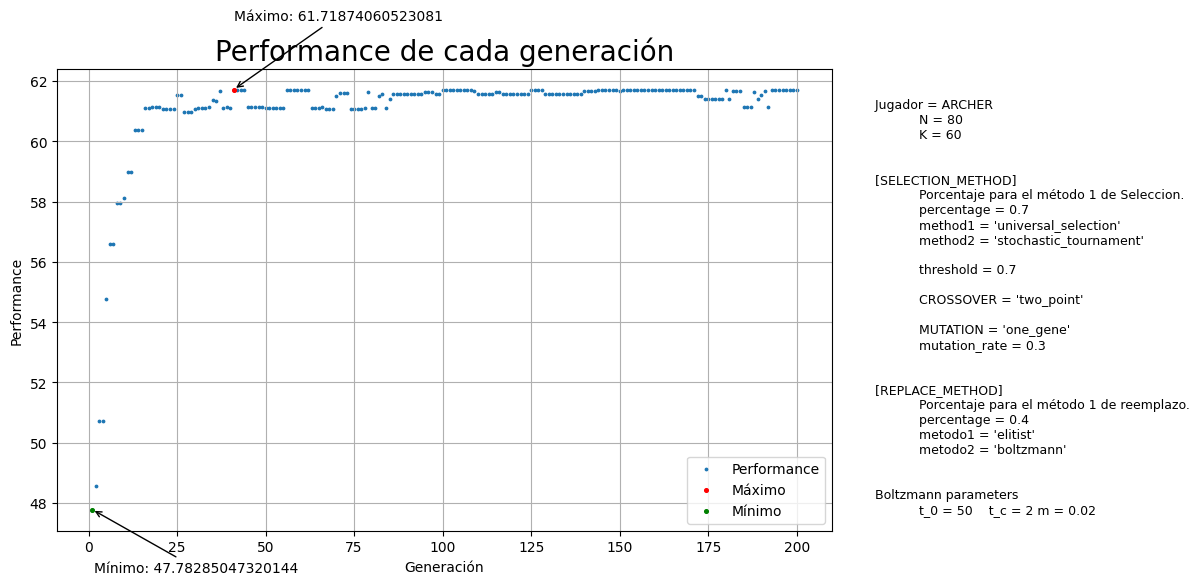

In [78]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
df = pd.read_csv('datos-Prueba1.csv')

# Encontrar el valor máximo y mínimo de la columna 'performance'
max_performance = df['performance'].max()
min_performance = df['performance'].min()

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(df['generation'], df['performance'], label='Performance', s=3)
plt.scatter(df['generation'].iloc[df['performance'].idxmax()], max_performance, color='red', label='Máximo', s=7)
plt.scatter(df['generation'].iloc[df['performance'].idxmin()], min_performance, color='green', label='Mínimo', s=7)
plt.xlabel('Generación')
plt.ylabel('Performance')
plt.title('Performance de cada generación', fontsize=20)
plt.legend()
plt.grid(True)

# Anotar los valores mínimo y máximo
plt.annotate(f'Máximo: {max_performance}', 
             xy=(df['generation'].iloc[df['performance'].idxmax()], max_performance),
             xytext=(0, 50), textcoords='offset points',
             arrowprops=dict(facecolor='red', arrowstyle='->'))

plt.annotate(f'Mínimo: {min_performance}', 
             xy=(df['generation'].iloc[df['performance'].idxmin()], min_performance),
             xytext=(1, -45), textcoords='offset points',
             arrowprops=dict(facecolor='green', arrowstyle='->'))

# Información adicional hacia la derecha de la leyenda del eje x
plt.text(1.05, 0.5, """
            \n Jugador = ARCHER
            N = 80
            K = 60
             
            \n [SELECTION_METHOD]
            Porcentaje para el método 1 de Seleccion.
            percentage = 0.7
            method1 = 'universal_selection'
            method2 = 'stochastic_tournament'
             
            threshold = 0.7                              
            
            CROSSOVER = 'two_point'
            
            MUTATION = 'one_gene'
            mutation_rate = 0.3

            \n [REPLACE_METHOD] 
            Porcentaje para el método 1 de reemplazo.
            percentage = 0.4
            metodo1 = 'elitist'
            metodo2 = 'boltzmann'
            
            \n Boltzmann parameters
            t_0 = 50    t_c = 2 m = 0.02  
            """,
         horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes , fontsize=9)

#plt.tight_layout()
plt.show()

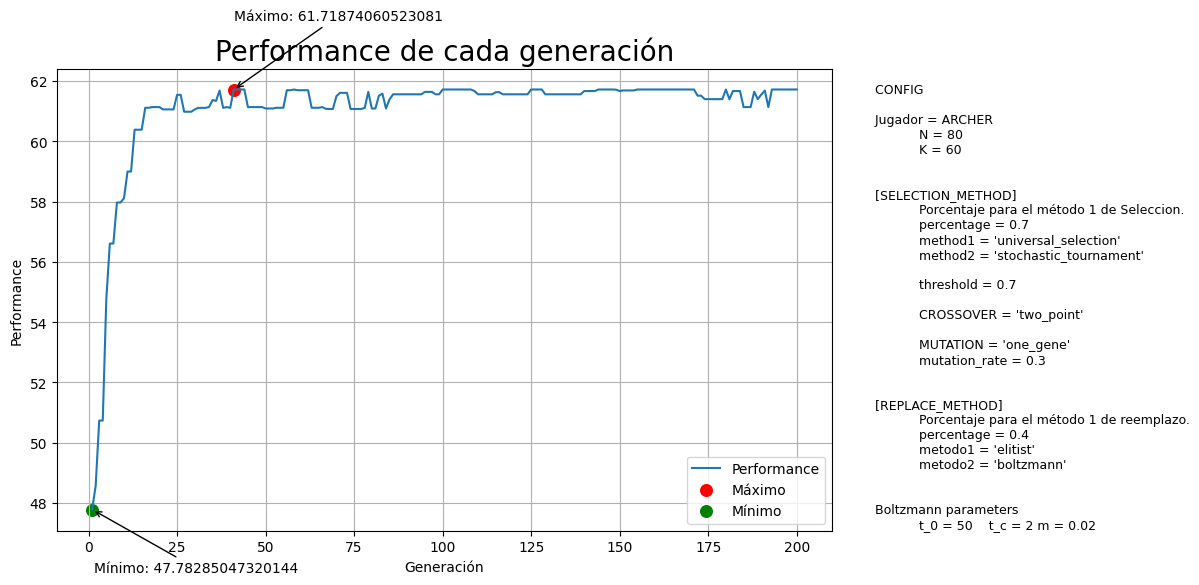

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
df = pd.read_csv('datos-Prueba1.csv')

# Encontrar el valor máximo y mínimo de la columna 'performance'
max_performance = df['performance'].max()
min_performance = df['performance'].min()

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(df['generation'], df['performance'], label='Performance')
plt.scatter(df['generation'].iloc[df['performance'].idxmax()], max_performance, color='red', label='Máximo', s=70)
plt.scatter(df['generation'].iloc[df['performance'].idxmin()], min_performance, color='green', label='Mínimo', s=70)
plt.xlabel('Generación')
plt.ylabel('Performance')
plt.title('Performance de cada generación', fontsize=20)
plt.legend()
plt.grid(True)

# Anotar los valores mínimo y máximo
plt.annotate(f'Máximo: {max_performance}', 
             xy=(df['generation'].iloc[df['performance'].idxmax()], max_performance),
             xytext=(0, 50), textcoords='offset points',
             arrowprops=dict(facecolor='red', arrowstyle='->'))

plt.annotate(f'Mínimo: {min_performance}', 
             xy=(df['generation'].iloc[df['performance'].idxmin()], min_performance),
             xytext=(1, -45), textcoords='offset points',
             arrowprops=dict(facecolor='green', arrowstyle='->'))

# Información adicional hacia la derecha de la leyenda del eje x
plt.text(1.05, 0.5, """
            \n CONFIG
            \n Jugador = ARCHER
            N = 80
            K = 60
             
            \n [SELECTION_METHOD]
            Porcentaje para el método 1 de Seleccion.
            percentage = 0.7
            method1 = 'universal_selection'
            method2 = 'stochastic_tournament'
             
            threshold = 0.7                              
            
            CROSSOVER = 'two_point'
            
            MUTATION = 'one_gene'
            mutation_rate = 0.3

            \n [REPLACE_METHOD] 
            Porcentaje para el método 1 de reemplazo.
            percentage = 0.4
            metodo1 = 'elitist'
            metodo2 = 'boltzmann'
            
            \n Boltzmann parameters
            t_0 = 50    t_c = 2 m = 0.02  
            """,
         horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes , fontsize=9)

# Agregar línea debajo del texto
#plt.axhline(y=0.1, color='gray', linestyle='--')

plt.show()


#### Graph

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

def graph(file,title):
    # Cargar los datos desde el archivo CSV
    df = pd.read_csv(file)

    # Encontrar el valor máximo y mínimo de la columna 'performance'
    max_performance = df['performance'].max()
    min_performance = df['performance'].min()

    # Graficar
    plt.figure(figsize=(10, 6))
    plt.scatter(df.index, df['performance'], label='Performance', s=10)
    #plt.scatter(df['generation'].iloc[df['performance'].idxmax()], max_performance, color='red', label='Máximo', s=7)
    #plt.scatter(df['generation'].iloc[df['performance'].idxmin()], min_performance, color='green', label='Mínimo', s=7)
    plt.xlabel('Individuos')
    plt.ylabel('Performance')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

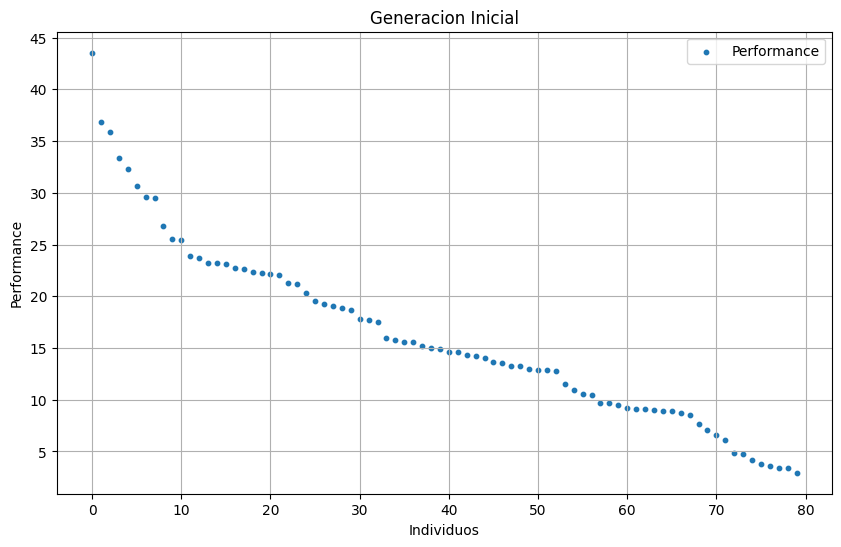

In [32]:
csv = 'generation0.csv'
titulo = 'Generacion Inicial'
graph(csv,titulo)

##### Selections

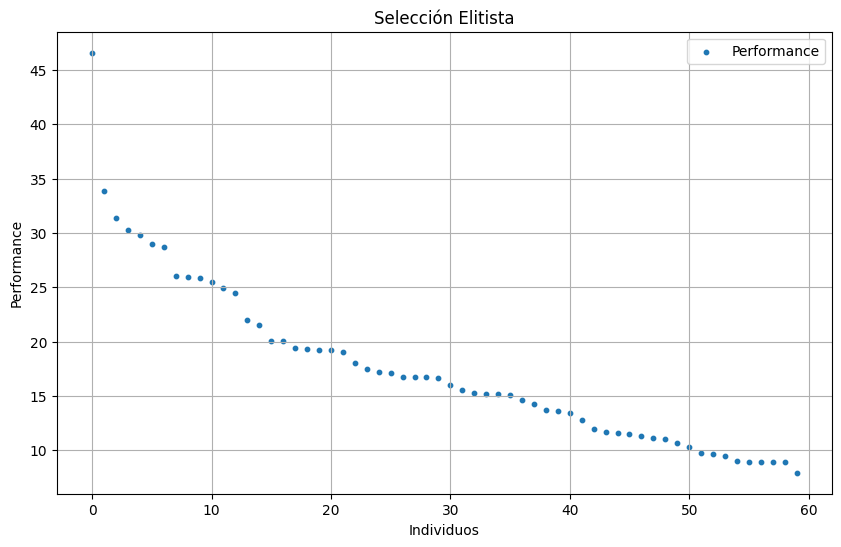

In [33]:
csv = 'elitist_selection.csv'
titulo = 'Selección Elitista'
graph(csv,titulo)

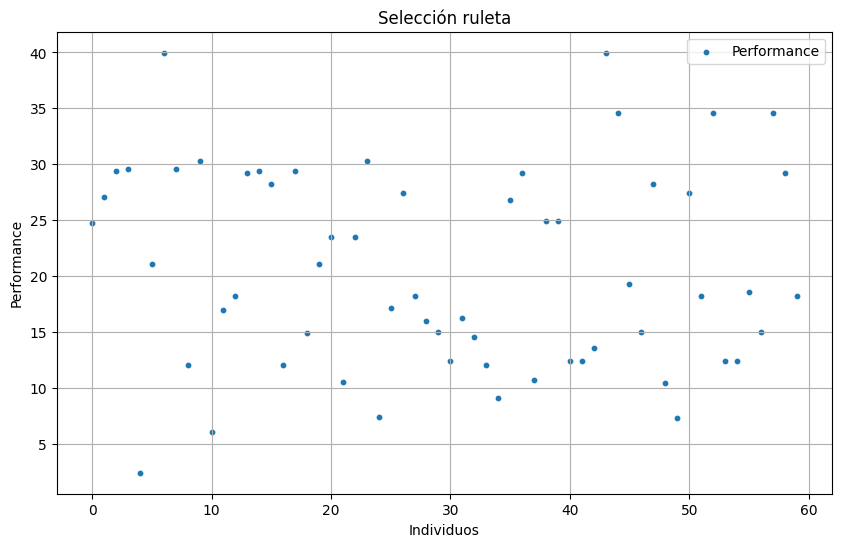

In [34]:
csv = 'roulette_wheel_selection.csv'
titulo = 'Selección ruleta'
graph(csv,titulo)

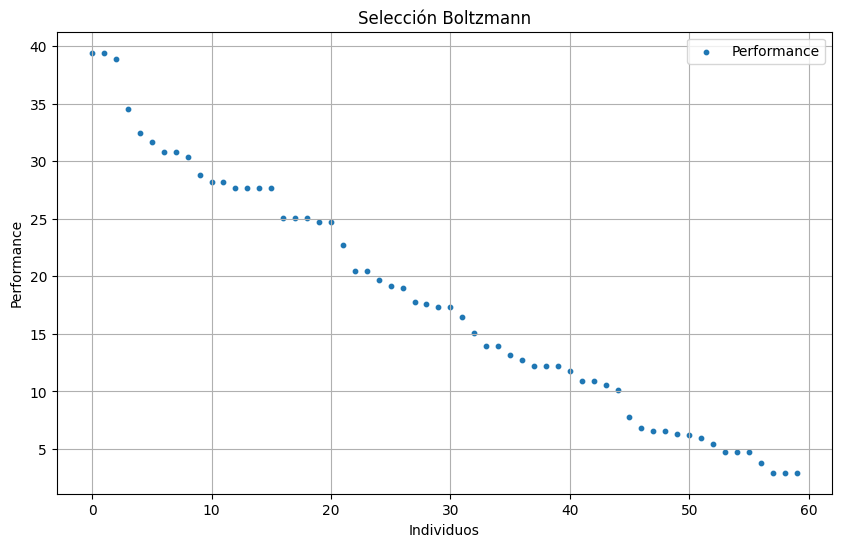

In [35]:
csv = 'boltzmann_selection.csv'
titulo = 'Selección Boltzmann'
graph(csv,titulo)

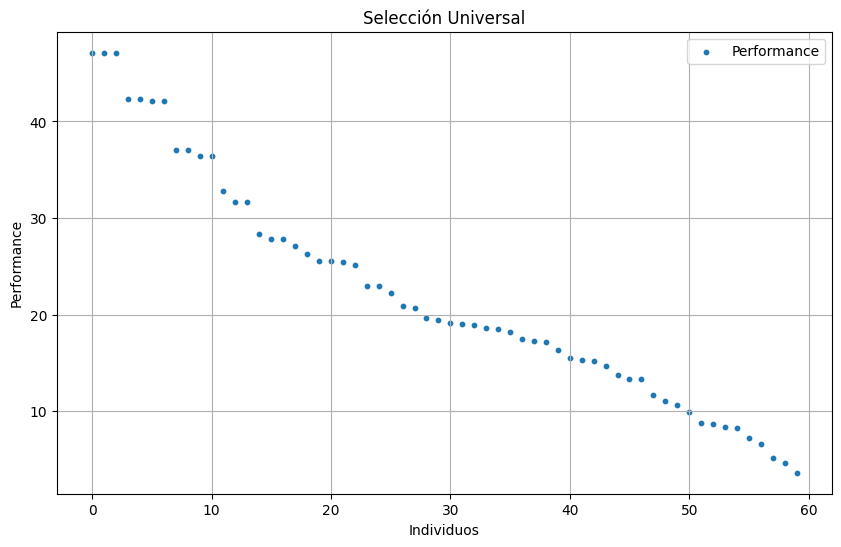

In [36]:
csv = 'universal_selection.csv'
titulo = 'Selección Universal'
graph(csv,titulo)

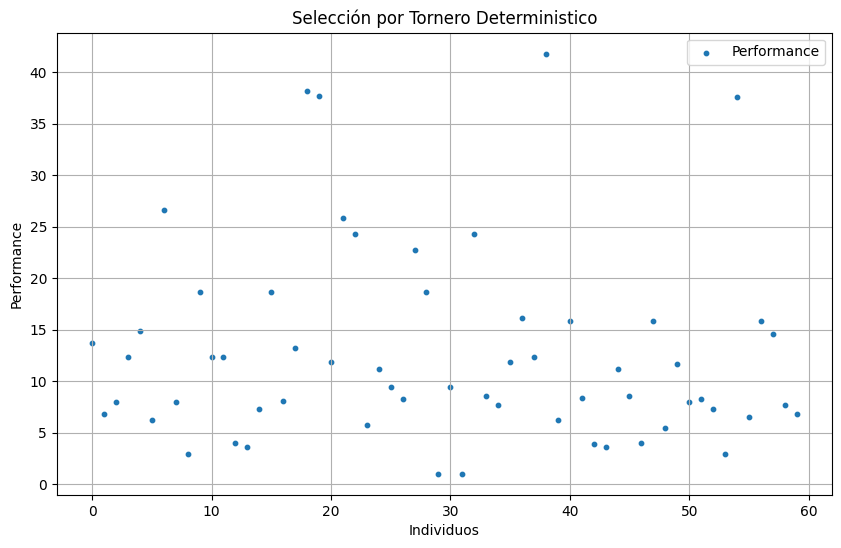

In [37]:
csv = 'deterministic_tournament.csv'
titulo = 'Selección por Tornero Deterministico'
graph(csv,titulo)

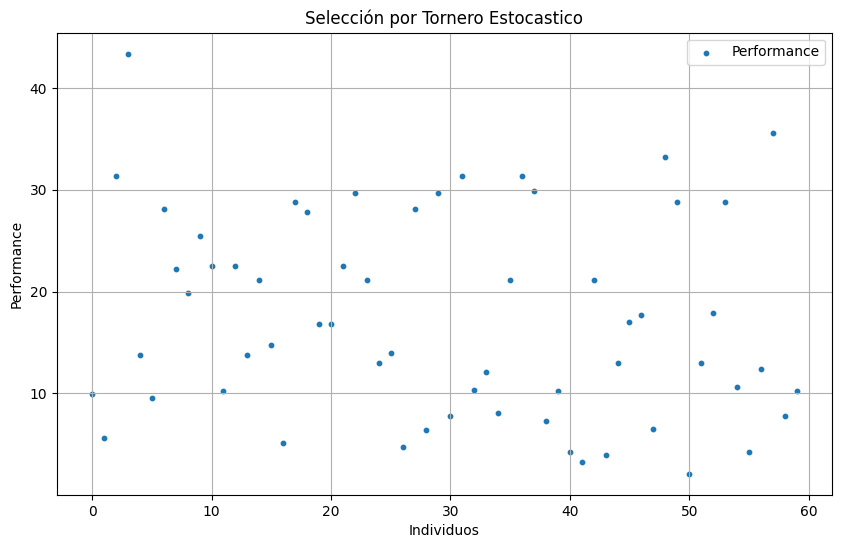

In [38]:
csv = 'stochastic_tournament_selection.csv'
titulo = 'Selección por Tornero Estocastico'
graph(csv,titulo)

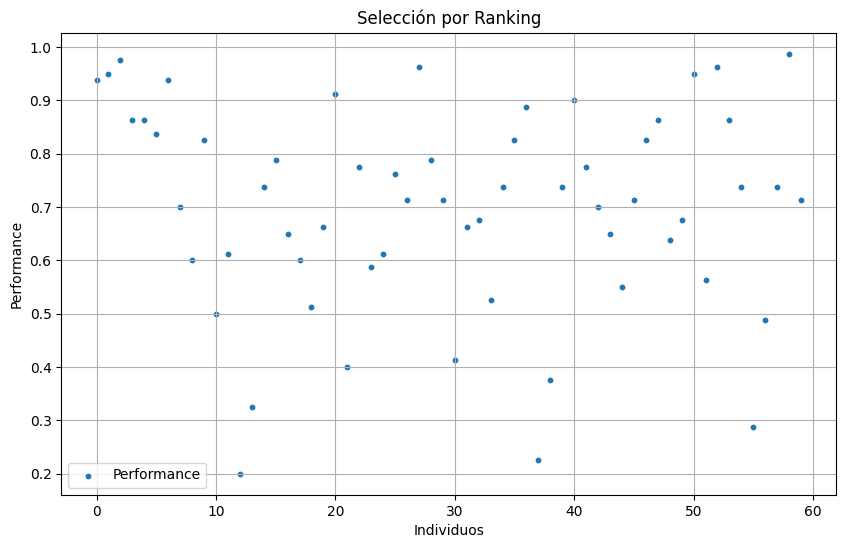

In [39]:
csv = 'rank_based_selection.csv'
titulo = 'Selección por Ranking'
graph(csv,titulo)


##### Crossovers

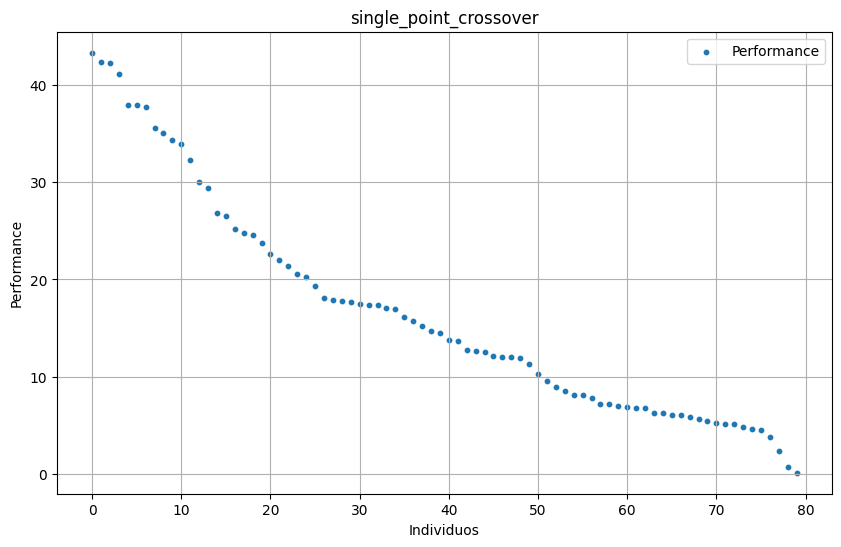

In [40]:
csv = 'single_point_crossover.csv'
titulo = 'single_point_crossover'
graph(csv,titulo)

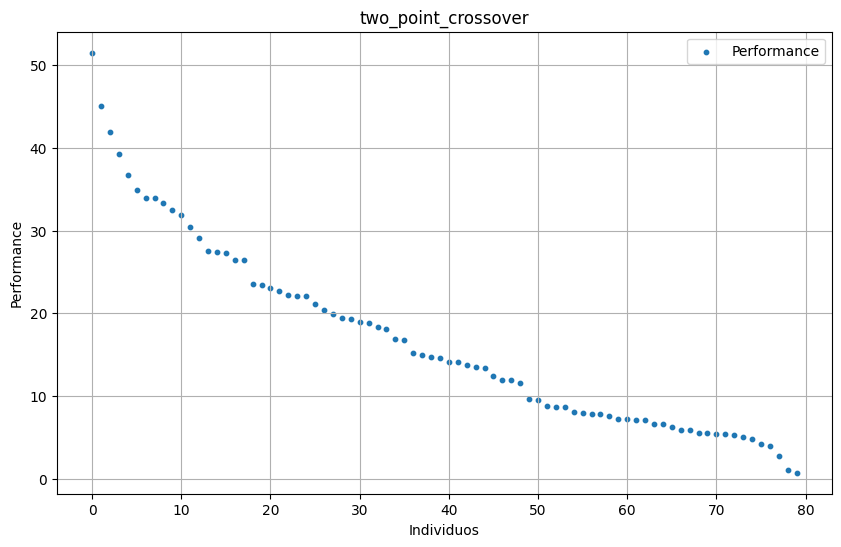

In [41]:
csv = 'two_point_crossover.csv'
titulo = 'two_point_crossover'
graph(csv,titulo)

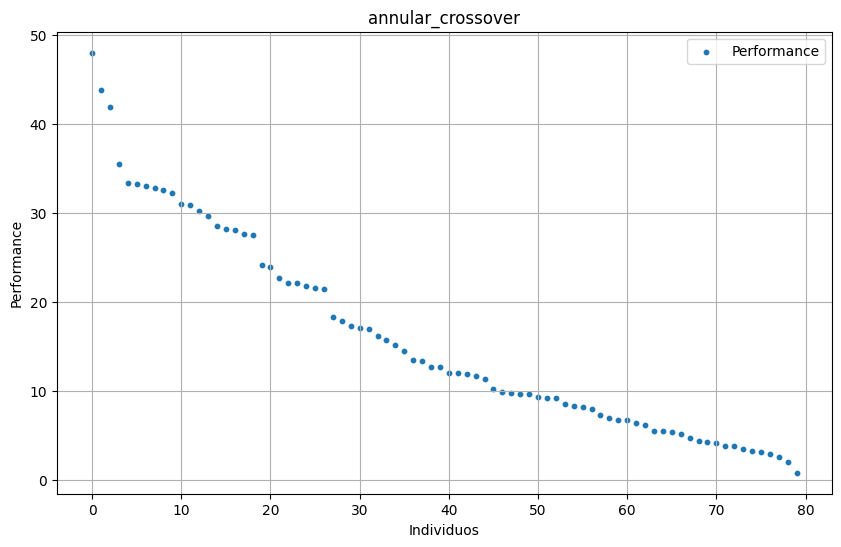

In [42]:
csv = 'annular_crossover.csv'
titulo = 'annular_crossover'
graph(csv,titulo)

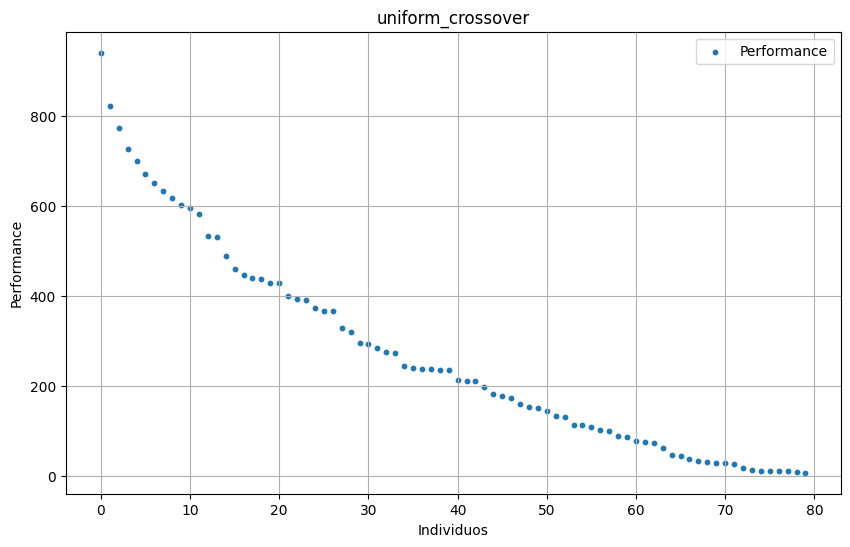

In [43]:
csv = 'uniform_crossover.csv'
titulo = 'uniform_crossover'
graph(csv,titulo)

##### Mutations

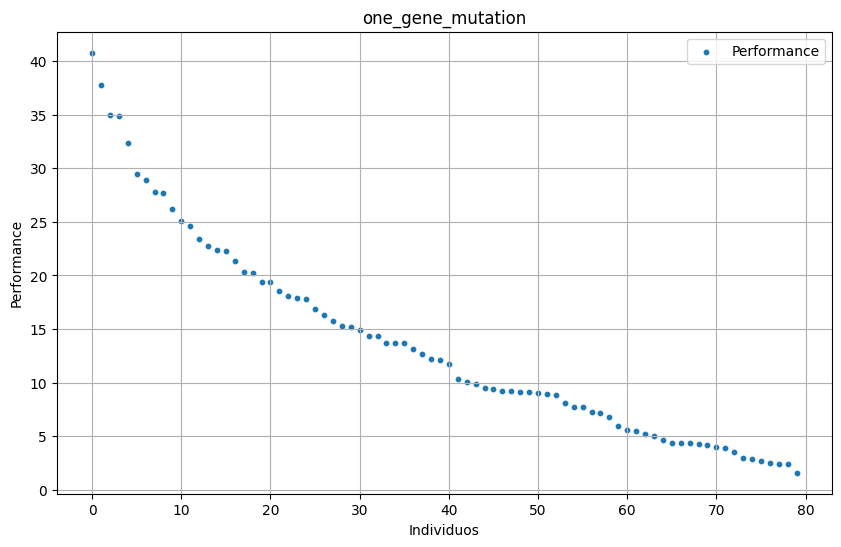

In [44]:
csv = 'one_gene_mutation.csv'
titulo = 'one_gene_mutation'
graph(csv,titulo)

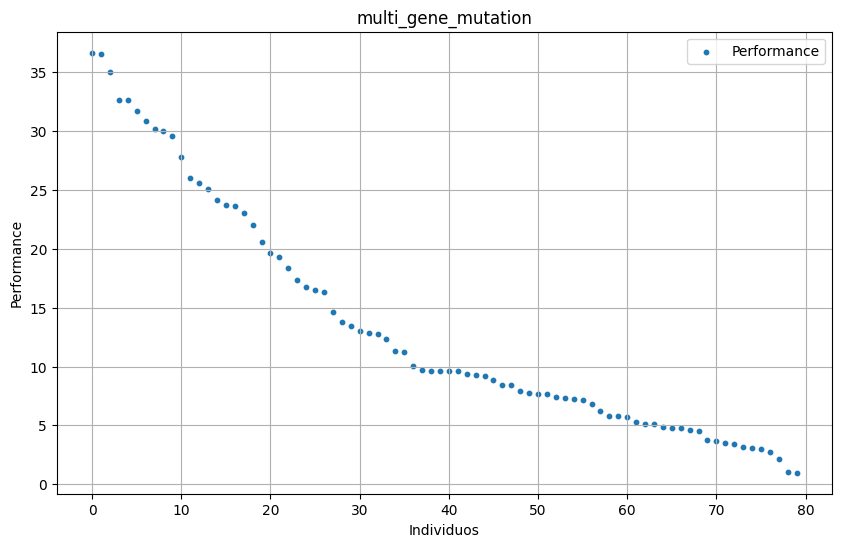

In [45]:
csv = 'multi_gene_mutation.csv'
titulo = 'multi_gene_mutation'
graph(csv,titulo)

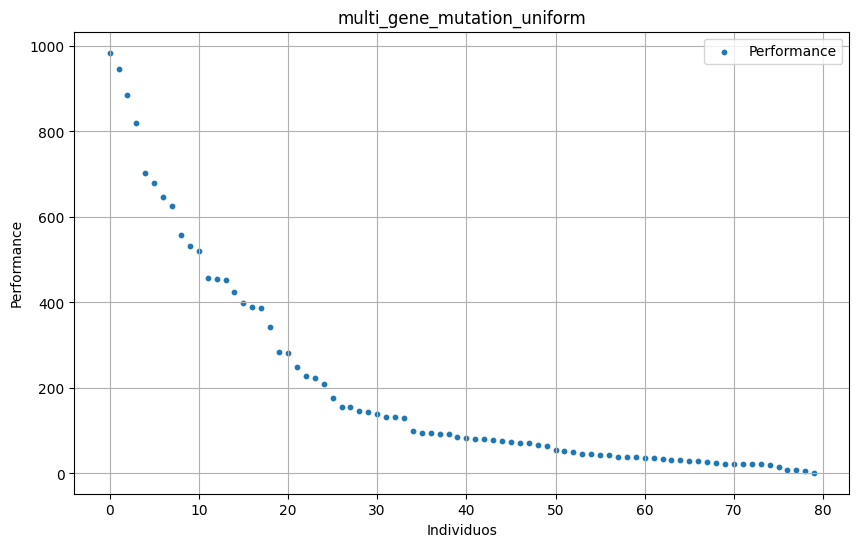

In [46]:
csv = 'multi_gene_mutation_uniform.csv'
titulo = 'multi_gene_mutation_uniform'
graph(csv,titulo)

##### Grafica del Motor AG

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
df = pd.read_csv("datos-Prueba1.csv")

# Encontrar el valor máximo y mínimo de la columna 'performance'
max_performance = df['performance'].max()
min_performance = df['performance'].min()

# Graficar
plt.figure(figsize=(10, 6))
plt.scatter(df['generation'], df['performance'], label='Performance', s=3)
plt.scatter(df['generation'].iloc[df['performance'].idxmax()], max_performance, color='red', label='Máximo', s=7)
plt.scatter(df['generation'].iloc[df['performance'].idxmin()], min_performance, color='green', label='Mínimo', s=7)
plt.xlabel('Generación')
plt.ylabel('Performance')
plt.title('Performance por generaciones')
plt.legend()
plt.grid(True)
plt.show()